## 모든 모델 만든것 추가해서 Ensemble 
## 0과 1로 나온 결과만 넣고 평균 0.5 이상 -> 1
## 0.5 미만 -> 0

---

### 현재 모델 GM, BGM, LOF, AutoEncoder, Hotelling T2

In [385]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

In [386]:
test = pd.read_csv('C:/Users/user/github/Data/aifactory/test_data.csv')
train = pd.read_csv('C:/Users/user/github/Data/aifactory/train_data.csv')


In [387]:
result = pd.DataFrame(index = test.index ,columns=['gm','bgm','hotelling','LOF','autoencoder'], data=0)

In [388]:
train = train.drop('out_pressure', axis=1)

In [389]:
test = test.drop('out_pressure',axis=1)

In [390]:
train_x_1 = train[(train['type']==0) | (train['type']==4)| (train['type']==5) | (train['type']==6) | (train['type']==7)]
train_x_2 = train[train['type'] == 1]
train_x_3 = train[train['type'] == 2]
train_x_4 = train[train['type'] == 3]

In [391]:
test_x_1 = test[(test['type']==0) | (test['type']==4)| (test['type']==5) | (test['type']==6) | (test['type']==7)]
test_x_2 = test[test['type'] == 1]
test_x_3 = test[test['type'] == 2]
test_x_4 = test[test['type'] == 3]

In [392]:
train_x_1 = train_x_1.drop('type', axis=1)
train_x_2 = train_x_2.drop('type', axis=1)
train_x_3 = train_x_3.drop('type', axis=1)
train_x_4 = train_x_4.drop('type', axis=1)

In [393]:
test_x_1 = test_x_1.drop('type', axis=1)
test_x_2 = test_x_2.drop('type', axis=1)
test_x_3 = test_x_3.drop('type', axis=1)
test_x_4 = test_x_4.drop('type', axis=1)

In [394]:
from sklearn.mixture import GaussianMixture

# GMM: n_components = 모델의 총 수
gm_1 = GaussianMixture(n_components=4, covariance_type = 'full',n_init=30, random_state=42)
gm_1.fit(train)

GaussianMixture(n_components=4, n_init=30, random_state=42)

In [395]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=4, n_init=15, random_state=42)
bgm.fit(train)
np.round(bgm.weights_, 2)

array([0.58, 0.29, 0.12, 0.01])

In [396]:
print(gm_1.converged_)
print(bgm.converged_)

True
True


In [397]:
densities = gm_1.score_samples(test)
density_threshold = np.percentile(densities, 4)

In [398]:
bgm_densities = bgm.score_samples(test)
bgm_density_threshold = np.percentile(bgm_densities, 4)

In [399]:
print(density_threshold)
print(bgm_density_threshold)

-56446.90450995895
-1352.622579262747


Text(0.5, 1.0, 'gmm result')

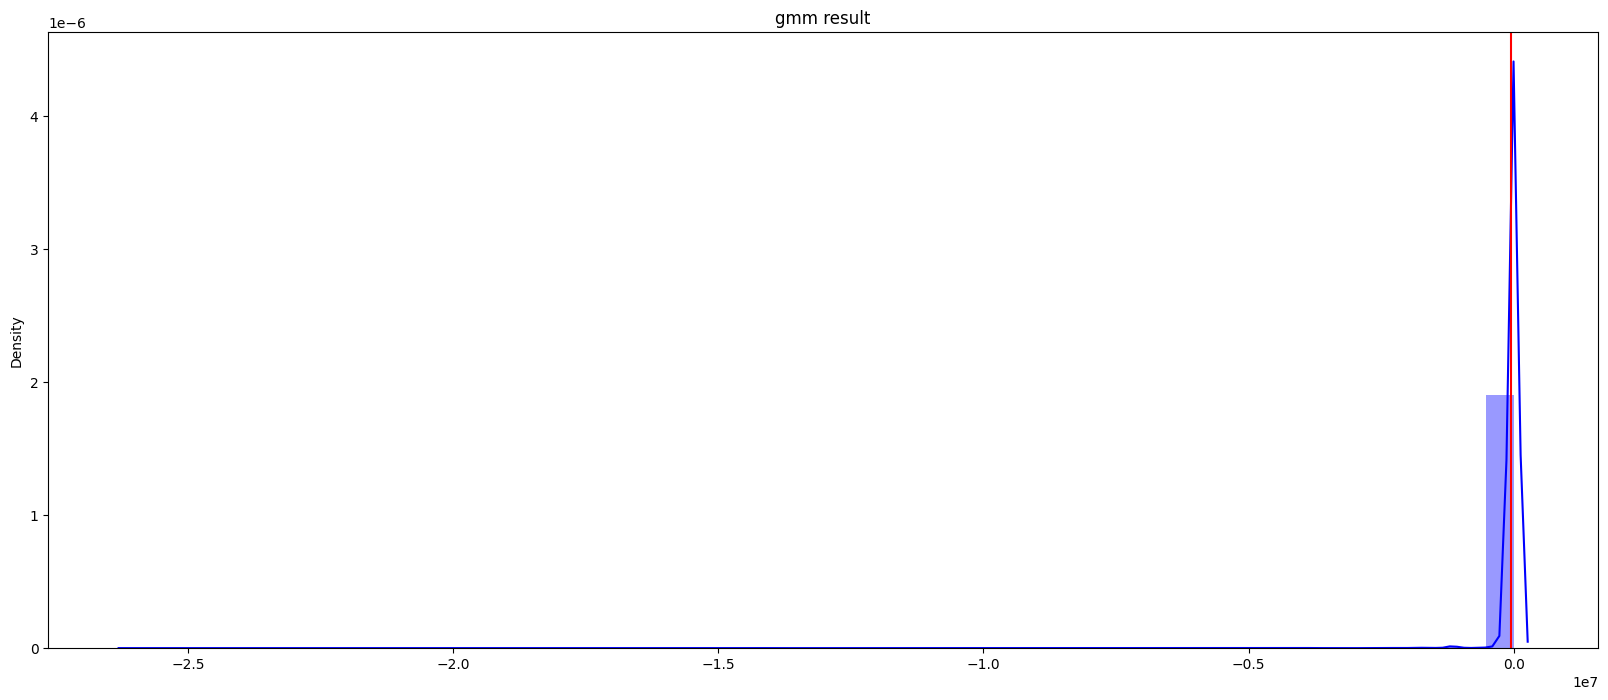

In [400]:
plt.figure(figsize=(20,8))
sns.distplot(densities, kde=True, color="b")
plt.axvline(density_threshold, color = 'red')
plt.title('gmm result')

Text(0.5, 1.0, 'bgm result')

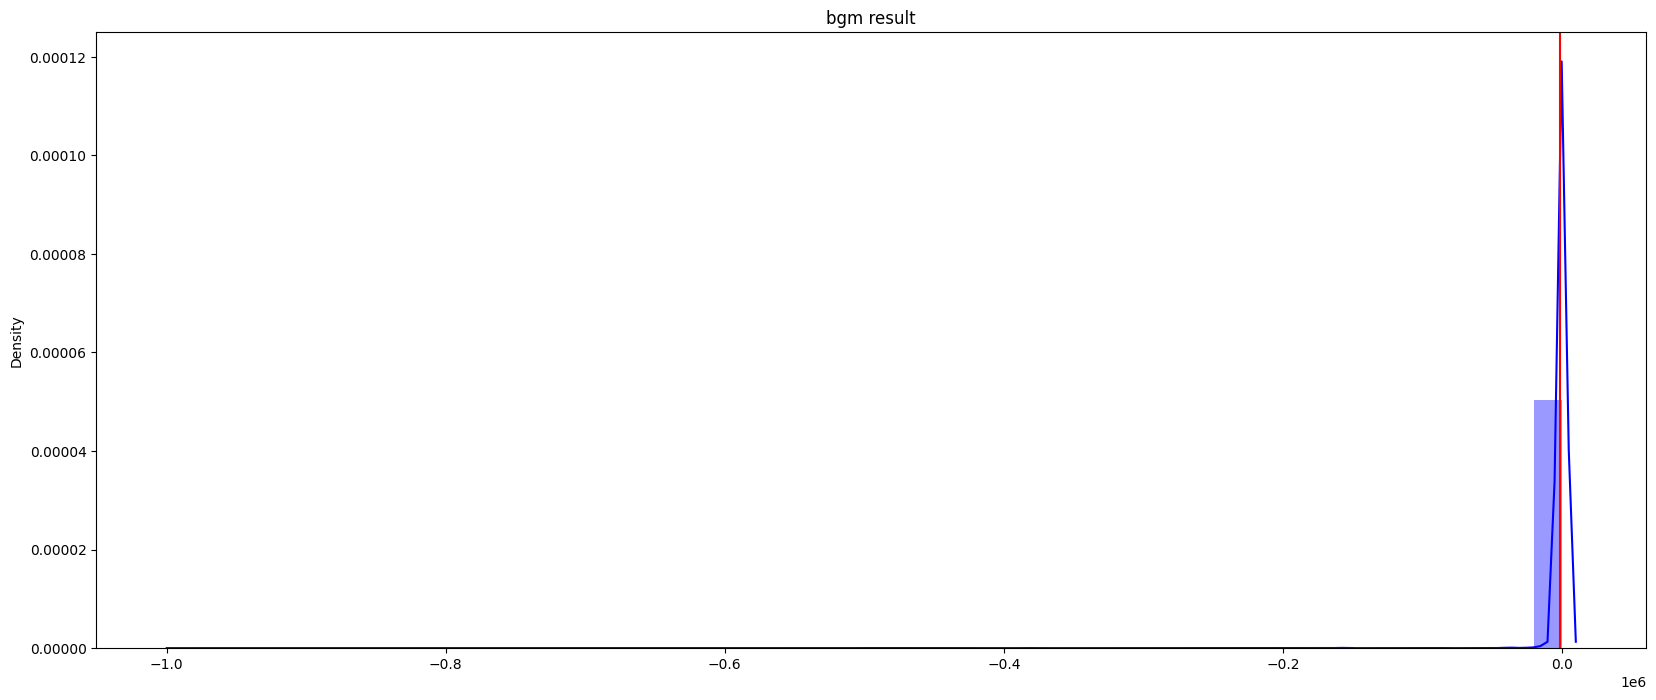

In [401]:
plt.figure(figsize=(20,8))
sns.distplot(bgm_densities, kde=True, color="b")
plt.axvline(bgm_density_threshold, color = 'red')
plt.title('bgm result')

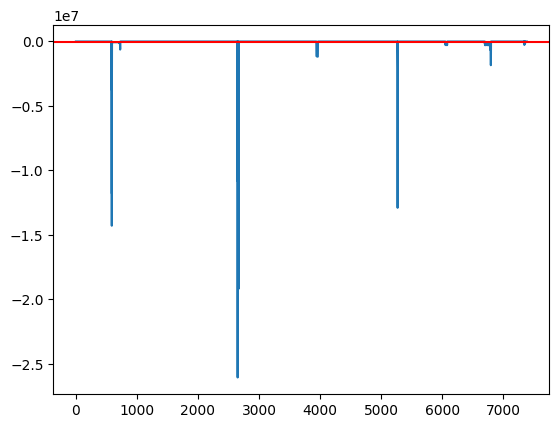

In [402]:
plt.plot(densities)
plt.axhline(density_threshold, color = 'r')
#plt.ylim(-90000,10)
plt.show()

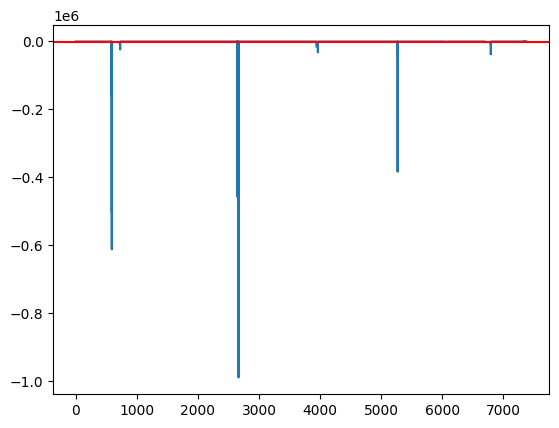

In [403]:
plt.plot(bgm_densities)
plt.axhline(bgm_density_threshold, color = 'r')
#plt.ylim(-2000,15)
plt.show()

In [404]:
anomalies = test[densities < density_threshold]

In [405]:
bgm_anomalies = test[bgm_densities < bgm_density_threshold]

In [406]:
anomalies

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
586,2.06,51.95,31.64,2476.0,59.34,3.58,0
587,1.35,41.20,20.65,1616.0,60.34,3.10,0
588,2.86,63.93,43.88,3434.0,61.34,4.11,0
590,2.89,64.34,44.30,3467.0,63.34,4.13,0
591,1.21,39.08,18.48,1446.0,64.34,3.00,0
...,...,...,...,...,...,...,...
6800,1.44,50.90,27.05,2072.0,63.02,3.55,6
7342,1.60,45.04,24.57,1923.0,61.37,3.27,7
7348,2.76,62.36,42.28,3309.0,76.77,4.04,7
7359,1.48,43.15,22.64,1772.0,59.69,3.18,7


In [407]:
bgm_anomalies

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
585,1.38,41.64,21.10,1651.0,58.34,3.12,0
586,2.06,51.95,31.64,2476.0,59.34,3.58,0
587,1.35,41.20,20.65,1616.0,60.34,3.10,0
588,2.86,63.93,43.88,3434.0,61.34,4.11,0
590,2.89,64.34,44.30,3467.0,63.34,4.13,0
...,...,...,...,...,...,...,...
6799,1.99,60.84,37.43,2867.0,71.86,3.99,6
6800,1.44,50.90,27.05,2072.0,63.02,3.55,6
7342,1.60,45.04,24.57,1923.0,61.37,3.27,7
7348,2.76,62.36,42.28,3309.0,76.77,4.04,7


In [408]:
result.loc[anomalies.index.tolist(), 'gm'] = 1
result.loc[bgm_anomalies.index.tolist(), 'bgm'] = 1

---

## Hotellings T2

In [409]:
import numpy as np

def hotellings_tsquare(trdat, tedat):
    '''
    Hotellings T-square : 공분산을 반영한 유클리디안 거리 (마할라노비스 거리)
    
    @param trdat : train data
    @param tedat : test data
    '''
    obs = trdat.shape[0]
    dim = trdat.shape[1]
    
    mu = trdat.apply(np.mean, axis=0) # 열단위 평균계산
    sinv = np.linalg.pinv(trdat.cov()) # 공분산 역행렬

    dte = (tedat-mu).values 
    
    Tsq_mat = np.zeros(tedat.shape[0])
    for i in range(tedat.shape[0]):
        Tsq_mat[i] = dte[i,:] @ sinv @ dte[i,:].transpose() # t-square distance
        
    return Tsq_mat

def bootstrap_limit(stat, alpha=0.05, bootstrap=300):
    '''
    Bootstrap sampling을 활용한 Control Limit 산출 기법
    
    @param stat : 통계량
    @param alpha : Control Limit을 정하기 위한 유의수준
    @param : bootstrap : 샘플링 횟수
    '''
    alpha = (alpha/2)*100
    alpha = 100 - alpha
    samsize = max(10000, len(stat))
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    # stat에서 samsize만큼 선택 후 75%분위수(alpha에따라 변경) 뽑기 이후 bootstrap만큼 반복 후 리스트로 만들고 평균 계산
    return limit

In [410]:
hotellings_1 = hotellings_tsquare(pd.DataFrame(train_x_1), pd.DataFrame(train_x_1))
hotellings_2 = hotellings_tsquare(pd.DataFrame(train_x_2), pd.DataFrame(train_x_2))
hotellings_3 = hotellings_tsquare(pd.DataFrame(train_x_3), pd.DataFrame(train_x_3))
hotellings_4 = hotellings_tsquare(pd.DataFrame(train_x_4), pd.DataFrame(train_x_4))


In [411]:
hotellings_1_all = hotellings_tsquare(pd.DataFrame(train_x_1), pd.DataFrame(test_x_1))
hotellings_2_all = hotellings_tsquare(pd.DataFrame(train_x_2), pd.DataFrame(test_x_2))
hotellings_3_all = hotellings_tsquare(pd.DataFrame(train_x_3), pd.DataFrame(test_x_3))
hotellings_4_all = hotellings_tsquare(pd.DataFrame(train_x_4), pd.DataFrame(test_x_4))


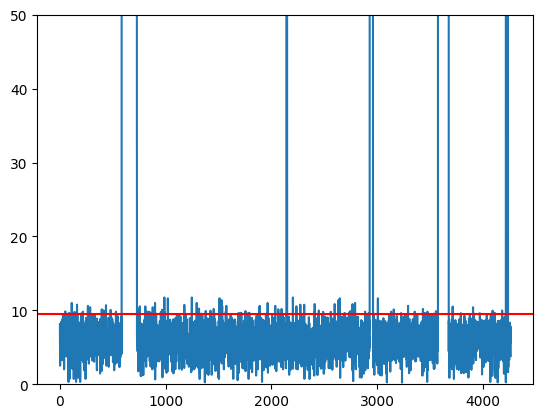

In [412]:
plt.plot(hotellings_1_all)
plt.axhline(y = bootstrap_limit(hotellings_1), color = 'r')
plt.ylim(0,50)
plt.show()

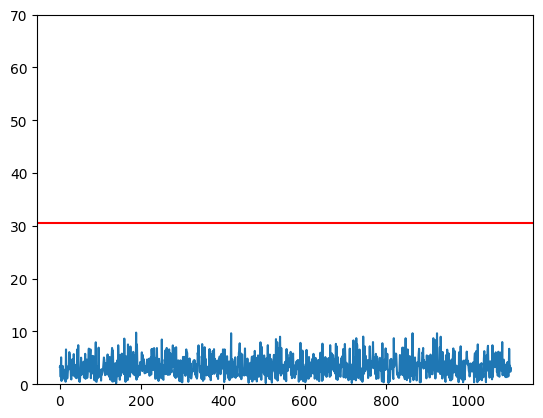

In [413]:
plt.plot(hotellings_2_all)
plt.axhline(y = bootstrap_limit(hotellings_2), color = 'r')
plt.ylim(0,70)
plt.show()

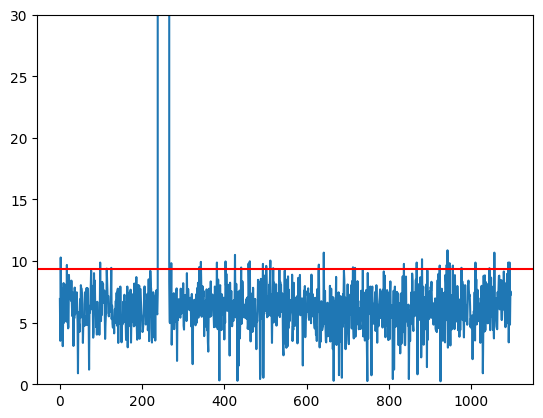

In [414]:
plt.plot(hotellings_3_all)
plt.axhline(y = bootstrap_limit(hotellings_3), color = 'r')
plt.ylim(0,30)
plt.show()

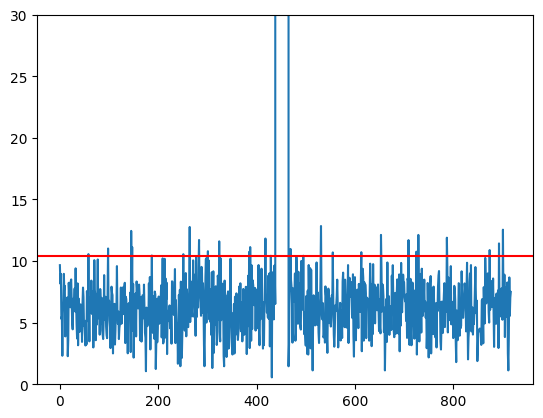

In [415]:
plt.plot(hotellings_4_all)
plt.axhline(y = bootstrap_limit(hotellings_4), color = 'r')
plt.ylim(0,30)
plt.show()

In [416]:
hotellings_1_anomalies = test_x_1[hotellings_1_all > bootstrap_limit(hotellings_1)]
hotellings_2_anomalies = test_x_2[hotellings_2_all > bootstrap_limit(hotellings_2)]
hotellings_3_anomalies = test_x_3[hotellings_3_all > bootstrap_limit(hotellings_3)]
hotellings_4_anomalies = test_x_4[hotellings_4_all > bootstrap_limit(hotellings_4)]

In [417]:
result.loc[hotellings_1_anomalies.index.tolist(), 'hotelling'] = 1
result.loc[hotellings_2_anomalies.index.tolist(), 'hotelling'] = 1
result.loc[hotellings_3_anomalies.index.tolist(), 'hotelling'] = 1
result.loc[hotellings_4_anomalies.index.tolist(), 'hotelling'] = 1

---

## LOF

In [418]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

In [419]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.5)

In [420]:
param_grid = {'n_neighbors' : [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28], 'contamination' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],}

In [421]:
clf = LocalOutlierFactor()

In [422]:
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid,
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=2
                          )

In [423]:
grid_search.fit(train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(estimator=LocalOutlierFactor(), n_jobs=-1,
             param_grid={'contamination': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9],
                         'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                         26, 27, 28]},
             scoring='accuracy', verbose=2)

In [424]:
grid_search.best_params_

{'contamination': 0.1, 'n_neighbors': 5}

In [425]:
clf2 = LocalOutlierFactor(n_neighbors=5, contamination=0.1)

In [426]:
clf2.fit(train)

LocalOutlierFactor(contamination=0.1, n_neighbors=5)

In [427]:
clf2.fit_predict(test)

array([-1,  1,  1, ...,  1,  1,  1])

In [428]:
lof_score = clf2.negative_outlier_factor_

In [429]:
lof_threshold = np.percentile(lof_score, 3)

(-6.0, 0.5)

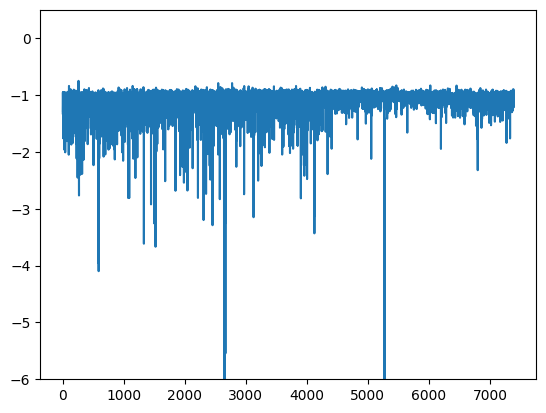

In [430]:
plt.plot(lof_score)
plt.ylim(-6,0.5)

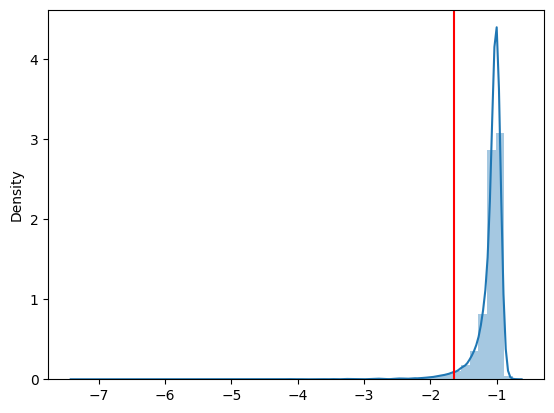

In [431]:
sns.distplot(lof_score)
plt.axvline(lof_threshold, color = 'r')
plt.show()

In [432]:
np.where(lof_score<lof_threshold)[0]

array([   6,   23,   27,   40,   69,   80,   98,  121,  124,  140,  147,
        167,  171,  173,  220,  227,  230,  236,  243,  246,  265,  266,
        287,  305,  314,  317,  327,  339,  340,  357,  359,  408,  462,
        489,  504,  555,  565,  586,  587,  588,  590,  591,  597,  599,
        632,  669,  675,  676,  677,  697,  712,  724,  725,  743,  750,
        768,  794,  805,  811,  824,  830,  837,  842,  852,  874,  890,
        963,  971,  973,  977,  989, 1018, 1068, 1072, 1089, 1093, 1137,
       1140, 1142, 1156, 1158, 1162, 1183, 1190, 1222, 1270, 1312, 1329,
       1335, 1387, 1446, 1467, 1498, 1520, 1521, 1527, 1534, 1549, 1645,
       1677, 1678, 1847, 1848, 1922, 1948, 1960, 1963, 1985, 2018, 2027,
       2043, 2048, 2078, 2128, 2202, 2215, 2262, 2300, 2307, 2343, 2348,
       2373, 2379, 2407, 2417, 2420, 2450, 2454, 2470, 2471, 2545, 2573,
       2589, 2630, 2642, 2643, 2650, 2653, 2655, 2656, 2658, 2660, 2662,
       2664, 2665, 2666, 2667, 2733, 2751, 2844, 28

In [433]:
result.loc[np.where(lof_score<lof_threshold)[0], 'LOF'] = 1

---

## AutoEncoder

In [434]:
scaler = StandardScaler()

In [435]:
train = scaler.fit_transform(train)

In [436]:
test = scaler.fit_transform(test)

In [437]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [438]:
input_dim = train.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mse')


In [439]:
autoencoder.fit(train, train, epochs=100, batch_size=50, shuffle=True)

Epoch 1/100
50/50 [==============================] - 0s 551us/step - loss: 1.2723
Epoch 2/100
50/50 [==============================] - 0s 510us/step - loss: 1.2021
Epoch 3/100
50/50 [==============================] - 0s 541us/step - loss: 1.1357
Epoch 4/100
50/50 [==============================] - 0s 510us/step - loss: 1.0401
Epoch 5/100
50/50 [==============================] - 0s 490us/step - loss: 0.9162
Epoch 6/100
50/50 [==============================] - 0s 510us/step - loss: 0.8178
Epoch 7/100
50/50 [==============================] - 0s 510us/step - loss: 0.7581
Epoch 8/100
50/50 [==============================] - 0s 510us/step - loss: 0.7228
Epoch 9/100
50/50 [==============================] - 0s 510us/step - loss: 0.7000
Epoch 10/100
50/50 [==============================] - 0s 510us/step - loss: 0.6842
Epoch 11/100
50/50 [==============================] - 0s 531us/step - loss: 0.6724
Epoch 12/100
50/50 [==============================] - 0s 510us/step - loss: 0.6632
Epoch 13/100


In [440]:
x_pred = autoencoder.predict(test)
mse = np.mean(np.power(test - x_pred, 2), axis=1)

231/231 [==============================] - 0s 417us/step


In [441]:
# 이상치 검출
auto_threshold = np.mean(mse) + 3*np.std(mse)
auto_outliers = np.where(mse > auto_threshold)[0]

In [442]:
auto_threshold

2.3002235459870675

In [443]:
auto_outliers

array([2406, 2413, 2416, 2418, 2420, 2425, 2428, 2429, 2430, 2455, 2457,
       2464, 2468, 2478, 2479, 2488, 2492, 2509, 2510, 2517, 2518, 2529,
       2541, 2560, 2573, 2575, 2594, 2612, 2619, 2622, 2624, 2637, 2668,
       2683, 2691, 2697, 2699, 2701, 2715, 2716, 2724, 2735, 2736, 2739,
       2745, 2750, 2753, 2758, 2764, 2768, 2781, 2782, 2793, 2797, 2802,
       2805, 2806, 2810, 2813, 2816, 2817, 2825, 2836, 2847, 2853, 2862,
       2873, 2879, 2887, 2888, 2889, 2895, 2913, 2915, 2918, 2935, 2940,
       2941, 2946, 2972, 2980, 2986, 2987, 3007, 3086, 3088, 3094, 3109,
       3110, 3112, 3142, 3143, 3154, 3155, 3170, 3182, 3185, 3198, 3211,
       3225, 3258, 3269, 3282, 3299, 3316, 3322, 3341, 3368, 3396, 3400,
       3407, 3416, 3417, 3431, 3500, 3507, 3529, 3542, 3559, 3572, 3605,
       3616, 3625, 3636, 3647, 3648, 3654, 3710, 3748, 3757, 3822, 3858,
       3866, 3867, 3871, 3880, 3888, 3897, 3935, 3942, 3950, 3955, 3958,
       3960, 4061, 4109, 4195, 4233, 4286, 4367, 43

In [444]:
result.loc[auto_outliers, 'autoencoder'] = 1

In [445]:
result['label'] = result.mean(axis=1)

In [446]:
for i in range(len(result)):
    if result.label[i] > 0.5:
        result.label[i] = 1
    else:
        result.label[i] = 0

<Axes: >

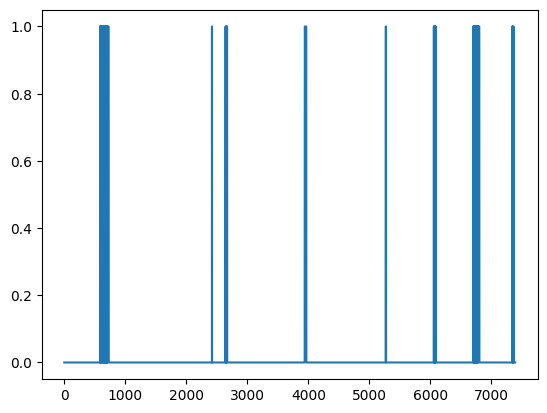

In [447]:
result.label.plot()

In [448]:
result.gm.value_counts()

0    7093
1     296
Name: gm, dtype: int64

In [449]:
result.bgm.value_counts()

0    7093
1     296
Name: bgm, dtype: int64

In [450]:
result.LOF.value_counts()

0    7167
1     222
Name: LOF, dtype: int64

In [451]:
result.hotelling.value_counts()

0    6879
1     510
Name: hotelling, dtype: int64

In [452]:
result.autoencoder.value_counts()

0    7237
1     152
Name: autoencoder, dtype: int64

In [453]:
result.to_csv('C:/Users/user/Desktop/result.csv', index=False)

In [454]:
result.label.value_counts()

0.0    7123
1.0     266
Name: label, dtype: int64

<Axes: >

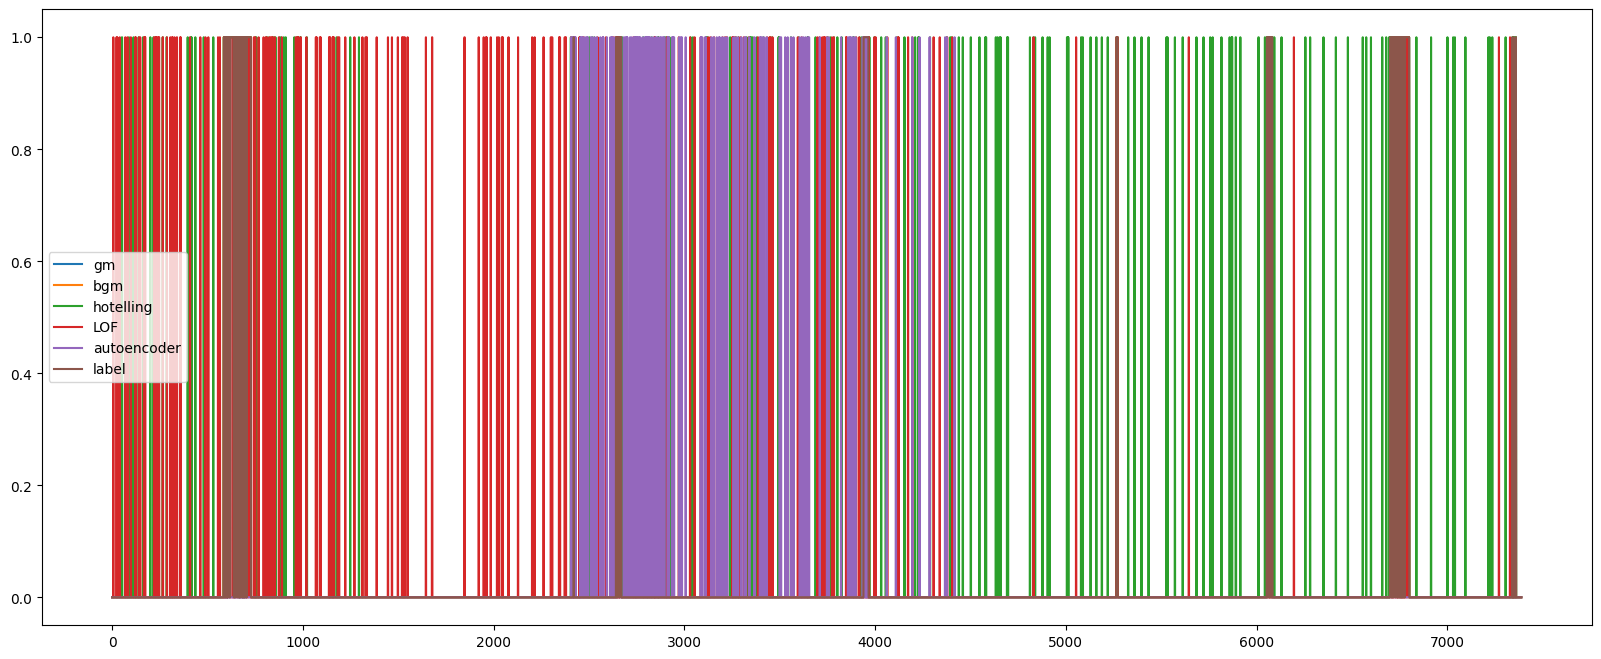

In [455]:
result.plot(figsize=(20,8))

<Axes: >

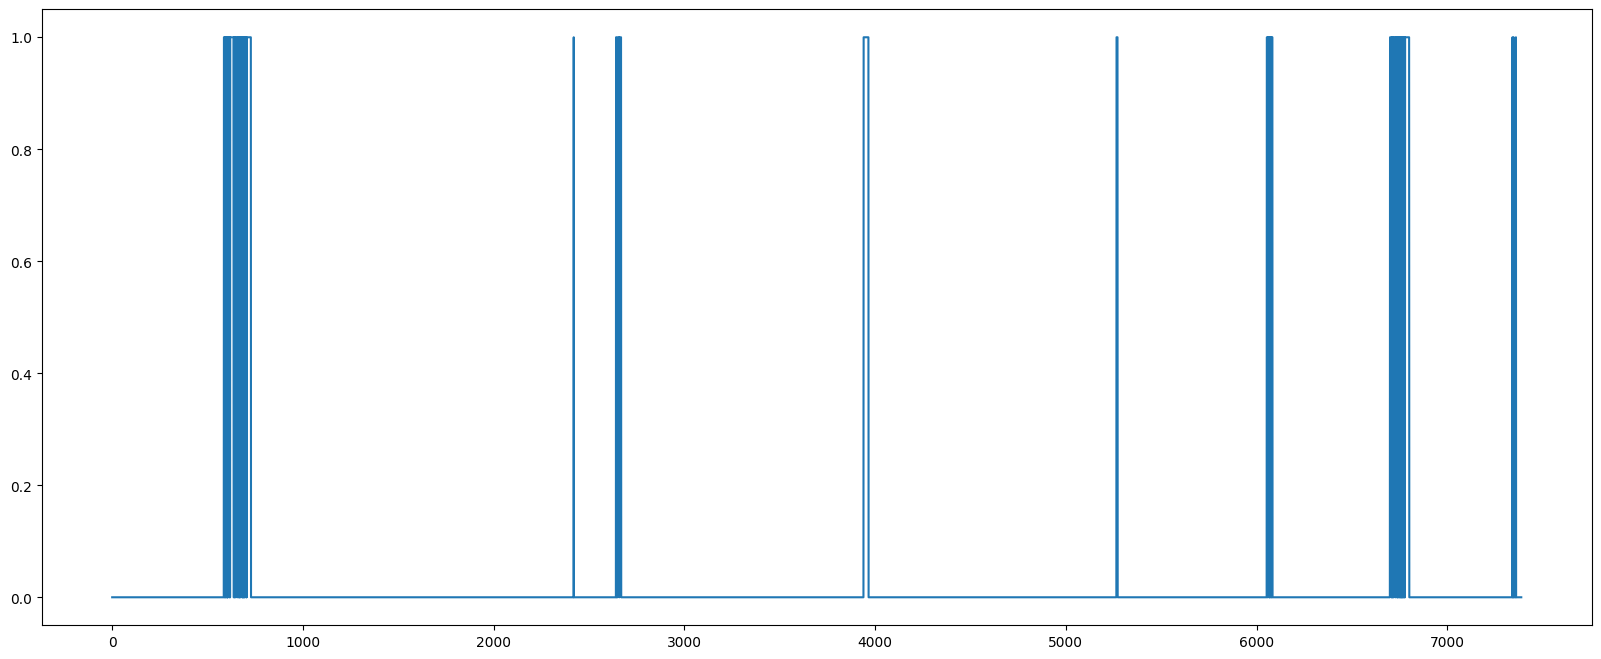

In [456]:
result.label.plot(figsize=(20,8))